# Chapter 3: Classification

Will be analyzing the MNIST dataset, 70,000 small images of high schooler handwritten digits. Data is labeled with which character it represents.

Fetch data using sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
x,y = mnist["data"], mnist["target"]

In [3]:
x.shape

(70000, 784)

Each image is 28x28 pixels = 784 pixels (features)
Featues have values from 0 (white) to 255 (black)

In [4]:
y.shape

(70000,)

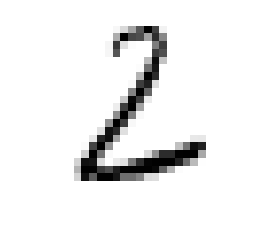

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

some_digit = x[15678]

some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

Split into training and test sets. MNIST is typically split into 60k/10k train/test

Split and shuffle

In [6]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

### Binary Classifier

Train a 5-detector (distinguishes 5 and not-5)

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


Train a Stochastic Gradient Descent Classifier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Classifier Performance Measures

More difficult than classifying regression models

In [9]:
from sklearn.model_selection import cross_val_score


cross_val_score(sgd_clf, x_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.9472 , 0.96015, 0.9645 ])

Approximately 10% of observations are 5s, so fully random classficiation should be right ~90% of the time.

To show this:
Make a fake classifier that classifies every observation as not-5

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y = None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype = bool)
    
cross_val_score(Never5Classifier(), x_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.9082 , 0.9091 , 0.91165])

Preferable to use a confusion matrix over straight accuracy

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54193,   386],
       [ 2177,  3244]])

Can simplify as

* precision = TP / (TP + FP)
* recall = TP / (TP + FN)

In [13]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.89366391184573
0.5984135768308431


So the classifier is correct on 89% of 5-calls, but only identifies 60% of 5's.

Often useful to use another metric: F1, the harmonic mean of precision and recall

F1 = 2 / ( 1/precision + 1/recall )

In [14]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7168268699591206


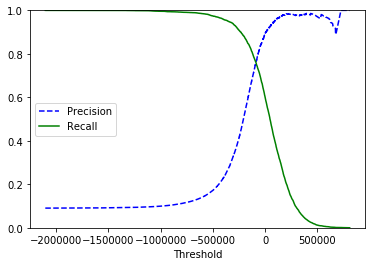

In [16]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3, method = "decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

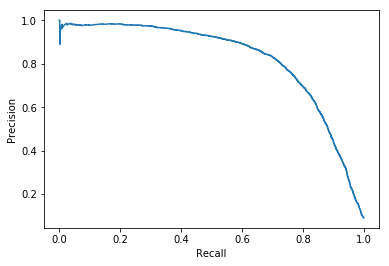

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

### The ROC Curve

Plots true positive rate (recall) vs false positive rate

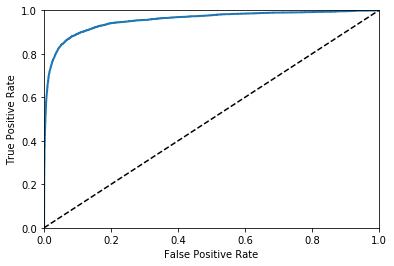

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()


In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9551620532933212

Use precision-recall plot when positive class is rare or when you care more about FP than FN

Redo analysis with a random forest model

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv = 3, method = "predict_proba")

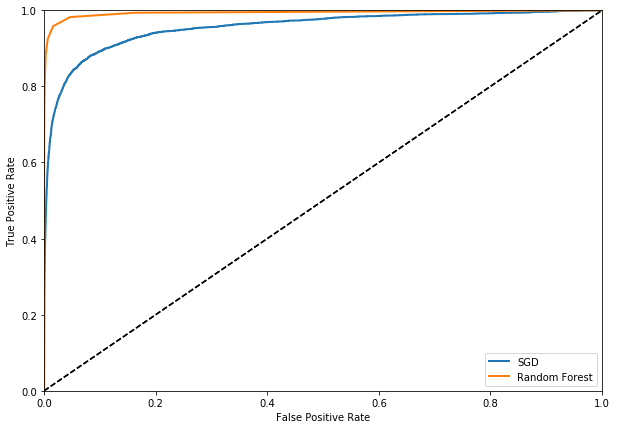

In [39]:
y_scores_forest = y_probas_forest[:,1] #score = prob of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.figure(figsize = (10, 7))
plot_roc_curve(fpr, tpr, "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")

plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9934458751574355

### Multiclass Classification

Can use a OneVsOneClassifier or OneVsRestClassifier when using binary classifier to do multiclass classifying. sklearn will do this automatically when using certain classifiers ( and a multiclass y variable.

In [48]:
sgd_clf.fit(x_train, y_train)
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-261582.27018765, -221283.84156839,  -25479.61049296,
         -56039.88646162, -839083.79471633, -166132.11278696,
         215278.62476461, -703414.02333482, -461540.67909844,
        -629058.66871049]])

In [49]:
np.argmax(some_digit_scores)

6

In [51]:
sgd_clf.classes_[6]

6.0

The classsifier got it wrong (2 vs 6)

Can force a OneVsOne or OneVsAll using certain classifiers

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([6.])

In [53]:
len(ovo_clf.estimators_)

45

45 estimators -> one for each pair tested. Number of pairs tested for N possible states is N * (N - 1) / 2

Can also use a Random Forest classifier

In [55]:
forest_clf.fit(x_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[2.]
[[0.  0.  0.5 0.1 0.  0.  0.4 0.  0.  0. ]]


Random Forest method gets it correct with a probability of 0.5. 6 is in a close second w/ p=0.4

Evaluate using cross_val_score

In [56]:
cross_val_score(sgd_clf, x_train, y_train, cv = 3, scoring = "accuracy")

array([0.874975  , 0.86544327, 0.85302795])

Pretty good. Random scoring would give ~0.1
Can improve by implementing scaling

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.90771846, 0.91304565, 0.90588588])

### Error Analysis

Once you have a model and have optimized it, further optimization is potentially possible by analyzing the types of errors using a confusion matrix

In [60]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5737,    3,   20,   12,    9,   46,   47,    8,   36,    5],
       [   1, 6484,   43,   28,    6,   42,    6,   12,  110,   10],
       [  54,   45, 5311,  108,   78,   30,   99,   53,  163,   17],
       [  50,   39,  137, 5359,    2,  236,   36,   56,  127,   89],
       [  24,   26,   37,   11, 5354,   11,   59,   31,   76,  213],
       [  77,   41,   33,  176,   69, 4641,  104,   27,  156,   97],
       [  36,   31,   46,    2,   41,  109, 5602,    6,   44,    1],
       [  28,   22,   67,   35,   51,   13,    7, 5799,   17,  226],
       [  49,  161,   72,  173,   15,  169,   54,   26, 4977,  155],
       [  48,   35,   29,   90,  162,   39,    3,  204,   70, 5269]])

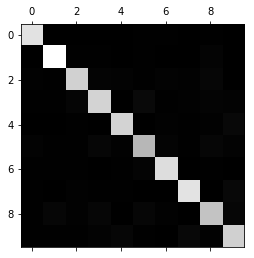

In [61]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

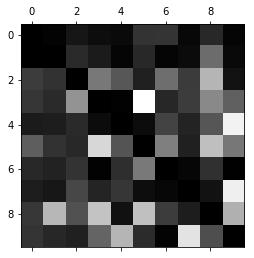

In [63]:
# Divide errors by number of images in corresponding class and remove accuracies to get error rates

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual values; columns represent predicted values.
Bright 8 and 9 cols indicate many numbers are misclassified as those two values.
Row 0 is very dark, indicating most zeros are classified correctly